In [1]:
import csv
import time
import re
import string
import requests
import pytz
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
from email.utils import parsedate_tz
from email.utils import mktime_tz
from sqlalchemy import Column, Integer, DateTime, Date, Interval, PickleType, String, select, func, create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [2]:
# Copyright (c) 2018 Sergio Lira <sergio.lira@gmail.com>
#
# MIT Licence. See http://opensource.org/licenses/MIT
#
# Created on 2018-12-03
#

engine = create_engine('sqlite://', echo=False)
Base = declarative_base(bind=engine)

class TimeEntry(Base):
    __tablename__ = 'time_entry'
    id = Column(Integer, primary_key=True)
    date_time = Column(DateTime)
    concepts = Column(PickleType)   
        
    def __init__(self, date_time, concepts):
        self.date_time = date_time
        self.concepts = concepts
        
class TimeSpent(Base):
    __tablename__ = 'time_spent'
    id = Column(Integer, primary_key=True)
    date = Column(Date)
    sdate = Column(String)
    year = Column(Integer)
    month = Column(Integer)
    day = Column(Integer)
    weekday = Column(Integer)
    time_delta = Column(Integer)
    concept = Column(String)
    
    def __init__(self, date, concept, time_delta):
        self.date = date
        self.sdate = date.strftime("%Y-%m-%d")
        self.month = int(date.strftime('%m'))
        self.day = int(date.strftime('%d'))
        self.year = int(date.strftime('%Y'))
        self.weekday = int(date.weekday())
        self.concept = concept
        self.time_delta = time_delta

Base.metadata.create_all()
Session = sessionmaker(bind=engine)

class TimeTracker:
    
    def __init__(self, content, n_days=15, n_months = 3, censor_concepts = False):
        self._content = content
        self.n_days = n_days
        self.n_months = n_months
        self._censor_concepts = censor_concepts
        self._db = Session()

    def load_content(self):
        """
        Initializes the TimeTracker database 
        If the content is of file type txt it initializes by parsing the file else by reading each row in content.
        returns row count added
        """
        #Set look back date and cut_date from max between n_days and n_months        
        look_back = max(self.n_days//31, self.n_months)
        self._cut_date = datetime.today() - relativedelta(months=look_back)
        self._cut_date = date(self._cut_date.date().year, self._cut_date.date().month, 1)
        
        if self._content.endswith('.txt'):
            return self._load_fromm_file()
        else:
            return self._load_fromm_file()
        
        
    def _extract_values_from_row(self, row):
        #Clean date row, format and extract date fields
        #row[0] = row[0].replace(",","").replace("at","")
        date_time= datetime.fromtimestamp(mktime_tz(parsedate_tz(row[0])))
        date_time = date_time.astimezone(pytz.utc)
        #Extract question and score
        concepts = row[1].strip().split(';')
        if self._censor_concepts:
            censored_concepts = []
            for concept in concepts:
                concept = ''.join(['*' if i%3==0 else ch for i, ch in enumerate(concept)])
                censored_concepts.append(concept)
            concepts = censored_concepts
        return TimeEntry(date_time, concepts)
        
    def _load_fromm_file(self):
        with open(self._content, "r") as txtfile:        
            reader = csv.reader(txtfile, delimiter='|', quotechar='"')    
            row_count = 0
            for row in reader:
                #Skip any row that does not matcht he format, including empty rows.
                if len(row) == 2:
                    #Clean date row, format and extract date fields
                    time_entry = self._extract_values_from_row(row)
                    #Only insert date if it will be used
                    if time_entry.date_time.date() >= self._cut_date:
                        #Write to in-memory database
                        self._db.add(time_entry)
                        self._db.commit()
                    row_count += 1
        return row_count
    
    def _calculate_time(self):
        entries = [entry for entry in self._db.query(TimeEntry).order_by(TimeEntry.date_time)]
        if len(entries) > 0 :
            last_entry = entries[0]
            for current_entry in entries[1:]:
                time_delta = current_entry.date_time - last_entry.date_time
                for concept in last_entry.concepts:
                    #print('{} {}: {}'.format(current_entry.sdate, concept, time_delta))
                    time_spent = TimeSpent(current_entry.date_time.date(),
                                           concept.strip(),
                                           time_delta.total_seconds())
                    self._db.add(time_spent)
                    self._db.commit()
                last_entry = current_entry
    
    def _get_last_n_days(self, n_days):
        return self._db.query(TimeSpent.date)\
                            .distinct(TimeSpent.date)\
                            .order_by(TimeSpent.date.desc())\
                            .limit(n_days)\
                            .subquery()
    
    def _get_sum_by_concept_last_n_days(self, n_days):
        last_n_days = self._get_last_n_days(n_days)        
        return self._db.query(TimeSpent.date,
                              TimeSpent.weekday,
                              TimeSpent.concept,
                              func.sum(TimeSpent.time_delta).label('sum_time'))\
                              .join(last_n_days, TimeSpent.date == last_n_days.c.date)\
                              .group_by(TimeSpent.date, TimeSpent.weekday, TimeSpent.concept).subquery()

    def get_last_n_days(self, n_days):
        return self._db.query(self._get_sum_by_concept_last_n_days(n_days)).all()
    
    def get_average_by_concept(self, n_days):
        last_n_days = self._get_sum_by_concept_last_n_days(n_days)
        subquery = self._db.query(last_n_days.c.concept,
                                  func.avg(last_n_days.c.sum_time).label('average_time'))\
                                 .group_by(last_n_days.c.concept).subquery()
        return self._db.query(subquery).order_by(subquery.c.average_time.desc()).all()
    
    def get_average_by_concept_and_day(self, n_days):
        last_n_days = self._get_sum_by_concept_last_n_days(n_days)
        subquery = self._db.query(last_n_days.c.weekday,
                                  last_n_days.c.concept,
                                  func.avg(last_n_days.c.sum_time).label('average_time'))\
                                 .group_by(last_n_days.c.concept, last_n_days.c.weekday).subquery()
        return self._db.query(subquery).order_by(subquery.c.weekday.asc(), subquery.c.average_time.desc()).all()
        

In [3]:
log_file = '/Users/sergio/Dropbox/Reference/Automation/LogTime.txt'
tt = TimeTracker(log_file, censor_concepts = True)
rows_loaded = tt.load_content()
print('Loaded {} time entry rows, inserted {}.'.format(rows_loaded, tt._db.query(TimeEntry.id).count()))
#for entry in tt._db.query(TimeEntry):
   #print(entry.id, entry.date_time, entry.sdate, entry.month, entry.day, entry.year, entry.concepts)
tt._calculate_time()
print('Found {} time spent entries.'.format(tt._db.query(TimeSpent.id).count()))

Loaded 1485 time entry rows, inserted 1485.
Found 1595 time spent entries.


In [4]:
print('\nConcept totals:\n')
print(tt._db.query(TimeSpent.concept, 
                   func.sum(TimeSpent.time_delta))\
                       .group_by(TimeSpent.concept)\
                       .order_by(func.sum(TimeSpent.time_delta).desc()).all())
print('\nLast N days:\n')
print(tt.get_last_n_days(14))
print('\nAverage by concept:\n')
print(tt.get_average_by_concept(14))
print('\nAverage by day:\n')
print(tt.get_average_by_concept_and_day(14))


Concept totals:

[('*le*pi*g', 1609813), ('*or*in*', 728261), ('*ea*in* -*Fi*ti*n', 457058), ('*am*', 434464), ('*el*-C*re', 292196), ('*ro*ec*', 282446), ('*ho*es', 222144), ('*om*ut*ng', 220956), ('*nt*rn*t *ed*a', 220452), ('*at*ng', 196166), ('*ni*e', 173614), ('*dm*ni*tr*ti*n', 166260), ('*ea*in* -*No*Fi*ti*n', 101513), ('*ov*', 71720), ('*ap*ne*e', 63857), ('*tu*yi*g', 58107), ('*oc*al*zi*g', 55420), ('*ed*ta*in*', 48743), ('*el*xi*g', 44548), ('*ud*ob*ok* o* P*dc*st*', 40637), ('*on*ex* S*it*h', 30602), ('*an*a', 25859), ('*ig*re*', 24100), ('*oc*or* a*d *ea*th', 24026), ('*ov*es*or*Se*ie*', 16920), ('*ho*pi*g', 15874), ('*xe*ci*in*', 5331), ('*Re*di*g * N*nF*ct*on', 3732)]

Last N days:

[(datetime.date(2019, 3, 3), 6, '*am*', 36925), (datetime.date(2019, 3, 3), 6, '*an*a', 2409), (datetime.date(2019, 3, 3), 6, '*ap*ne*e', 3259), (datetime.date(2019, 3, 3), 6, '*at*ng', 1836), (datetime.date(2019, 3, 3), 6, '*dm*ni*tr*ti*n', 3750), (datetime.date(2019, 3, 3), 6, '*ea*in* -*Fi*

In [5]:
d = pd.DataFrame(tt.get_average_by_concept(28), columns=['concept','time',])
d.time = d.time.apply(int)
d

,concept,time
0,*le*pi*g,27833
1,*or*in*,17479
2,*am*,11271
3,*ea*in* -*Fi*ti*n,8450
4,*om*ut*ng,5828
5,*ro*ec*,5619
6,*oc*or* a*d *ea*th,5004
7,*el*-C*re,4290
8,*ov*,4268
9,*ud*ob*ok* o* P*dc*st*,4177


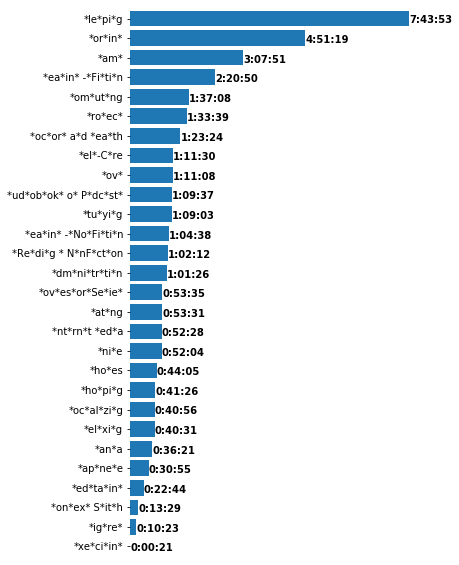

In [6]:
fig, ax = plt.subplots()
ax.barh(d['concept'],d['time'])
for i, v in enumerate(d['time']):
    m, s = divmod(v, 60)
    h, m = divmod(m, 60)
    ax.text(v + 3, i + .25, '{:d}:{:02d}:{:02d}'.format(h, m, s), color='black', fontweight='bold')
ax.invert_yaxis()
ax.xaxis.set_visible(False)
plt.autoscale(tight=True)
plt.box(False)
fig.set_size_inches(5,10)

plt.show()

https://www.digitalocean.com/community/tutorials/data-analysis-and-visualization-with-pandas-and-jupyter-notebook-in-python-3
http://pbpython.com/simple-graphing-pandas.html